# Classification and representation of `ethnicity`-related question formats with multiple responses

## A simulation exercise on how to model multiple response data on ethnicity

<u>This note was produced by the OSCE High Commissioner on National Minorities</u>

For questions, please contact:
* Peter Naderer at [peter.naderer@osce.org](mailto:peter.naderer@osce.org), and
* Sergiu Conovalu at [sergiu.conovalu@osce.org](mailto:sergiu.conovalu@osce.org)

In [129]:
import pandas as pd
import re
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from io import BytesIO
import squarify

In [44]:
# 1: Get 2004 and 2014 Census data from from the National Bureau of Statistics

url = "https://statistica.gov.md/files/files/Recensamint/Recensamint_pop_2014/Rezultate/Tabele/Caracteristici_populatie_RPL_2014_rom_rus_eng.xls"
response = requests.get(url)

df = pd.read_excel(BytesIO(response.content), sheet_name="7")

# Cleaning dataset
df = df.iloc[10:27, 0:3]
df.columns = ['ethnicity', '2004', '2014']
df = df[df['2004'].notna()]
df.reset_index(drop=True, inplace=True)


In [45]:
df.loc[8,'ethnicity'] = df['ethnicity'][8][15:34]

In [46]:
eng_names = {
    'Bulgari': 'Bulgarian',
    'Găgăuzi': 'Gagauz',
    'Moldoveni': 'Moldovan',
    'Roma': 'Roma',
    'Români': 'Romanian',
    'Ruşi': 'Russian',
    'Ucraineni': 'Ukrainian',
    'Alte etnii': "Others",
    'nu a declarat etnia': "Not declared"
}

df.loc[:,'ethnicity'] = df.loc[:,'ethnicity'].replace(eng_names)

df['2004'] = df['2004'].astype(int)

df_2004_2014 = df.copy()

In [47]:
df_2004_2014

,ethnicity,2004,2014
0,Moldovan,2564849,2068058.0
1,Ukrainian,282406,181035.0
2,Russian,201218,111726.0
3,Gagauz,147500,126010.0
4,Romanian,73276,192800.0
5,Bulgarian,65662,51867.0
6,Roma,12271,9323.0
7,Others,22130,13900.0
8,Not declared,14020,50082.0


In [97]:
# 2: Get data for 2024 Census

url = "https://statistica.gov.md/files/files/ComPresa/Recensamant/2024/Ro/Anexa_Caracteristici_Etnoculturale_RPL2024.xlsx"
response = requests.get(url)
df = pd.read_excel(BytesIO(response.content), sheet_name="5.1")


In [98]:

df = df.iloc[11:20, 1:3]
cols =  ["ethnicity", "2024"]
df.columns = cols
df = df.reset_index(drop=True)


In [99]:
df['ethnicity'] = df['ethnicity'].str.strip()

In [100]:
df

,ethnicity,2024
0,Moldoveni,1848670
1,Români,193197
2,Ucraineni,123586
3,Ruși,81630
4,Găgăuzi,97205
5,Bulgari,38236
6,Romi/Țigani,9356
7,Alte etnii,13879
8,Nu au declarat etnia,3448


In [101]:

eng_names = {
    'Bulgari': 'Bulgarian',
    'Găgăuzi': 'Gagauz',
    'Moldoveni': 'Moldovan',
    'Romi/Țigani': 'Roma',
    'Români': 'Romanian',
    'Ruși': 'Russian',
    'Ucraineni': 'Ukrainian',
    'Alte etnii': "Others",
    'Nu au declarat etnia': "Not declared"
}


In [102]:
df['ethnicity'] = df['ethnicity'].replace(eng_names)

df['2024_p'] = df[['2024']].apply(lambda x: x / sum(x))


In [103]:
df

,ethnicity,2024,2024_p
0,Moldovan,1848670,0.767335
1,Romanian,193197,0.080191
2,Ukrainian,123586,0.051297
3,Russian,81630,0.033883
4,Gagauz,97205,0.040347
5,Bulgarian,38236,0.015871
6,Roma,9356,0.003883
7,Others,13879,0.005761
8,Not declared,3448,0.001431


In [104]:

df = df.merge(df_2004_2014, on='ethnicity')

In [105]:
df

,ethnicity,2024,2024_p,2004,2014
0,Moldovan,1848670,0.767335,2564849,2068058.0
1,Romanian,193197,0.080191,73276,192800.0
2,Ukrainian,123586,0.051297,282406,181035.0
3,Russian,81630,0.033883,201218,111726.0
4,Gagauz,97205,0.040347,147500,126010.0
5,Bulgarian,38236,0.015871,65662,51867.0
6,Roma,9356,0.003883,12271,9323.0
7,Others,13879,0.005761,22130,13900.0
8,Not declared,3448,0.001431,14020,50082.0


In [106]:
# 2. Loading Ethnobarometer data and variable names

url = "https://files.hcnmplatform.org/3_ETNO_database_final_REORDERED_Version%206_EN.XLSX"
response = requests.get(url)

df_e = pd.read_excel(BytesIO(response.content),
                     sheet_name='ETNO_database_final_text data')
vars_e = pd.read_excel(BytesIO(response.content), sheet_name='New structure')

vars_e.columns = ('variable', 'text')
vars_e.index = vars_e['variable'].reset_index(drop=True)
vars_e = vars_e.drop('variable', axis=1)

# Extract needed data on ethnic self-identification
df_e_ethnicity = df_e.loc[:, [
    "ETHN-GROUP", "Q2_01", "Q2_02", "Q2_03", "Q2_04", "Q2_05", "Q2_06",
    "Q2_07", "Q2_08", "Q2_09"
]]
# Transform into numerical values to allow for suming
df_e_ethnicity.replace({'Yes': 1, 'No': 0}, inplace=True)

# 3. Estimating Moldova's 2024 population by ethnic group
#
#  We start by creating a `dataframe` with exisiting official data on `ethnicity` and then estimate the population data by ethnicity for the year `2024` using a exponential regression.



/tmp/ipykernel_25105/3380495917.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_e_ethnicity.replace({'Yes': 1, 'No': 0}, inplace=True)


In [107]:
### Estimate proportions of persons indicating multiple identities in 2024

# The Ethnobaromter did not include data on "Others" and "Not declared". We will therefore simulate two additional sample clusters of 400 respondents for each of those categories.
new_rows = [['Others'] + [0] * 8 + [1]
            for _ in range(400)] + [['Not declared'] + [0] * 8 + [1]
                                    for _ in range(400)]

new_data = pd.DataFrame(new_rows, columns=df_e_ethnicity.columns)

# Concatenate existing and new data
df_e_ethnicity_grouped = pd.concat([df_e_ethnicity, new_data],
                                   ignore_index=True)

# Adding the count of identity for each row (excluding Q2_09 for None)
df_e_ethnicity_grouped[
    'identity_count'] = df_e_ethnicity_grouped.loc[:, ~df_e_ethnicity.columns.
                                                   isin(
                                                       ['ETHN-GROUP', "Q2_09"]
                                                   )].apply(sum, axis=1)

# Creating a new DF grouped by ethnic group and counts of the numbers of identities indicated
df_e_ethnicity_grouped = df_e_ethnicity_grouped.loc[:, [
    'ETHN-GROUP', 'identity_count'
]].groupby('ETHN-GROUP').value_counts().reset_index(name='count')

# Merging estimated 2024 probabilities into df
df_e_ethnicity_grouped = pd.merge(df_e_ethnicity_grouped,
                                  df,
                                  left_on="ETHN-GROUP",
                                  right_on="ethnicity")

# We adjust the sample count with the estimated 2024 proportions.
df_e_ethnicity_grouped['weighted_count'] = df_e_ethnicity_grouped[
    'count'] * df_e_ethnicity_grouped['2024_p']

# Creating a column that normalizes the weighted count, within each group
df_e_ethnicity_grouped[
    'count_normalized_within_group'] = df_e_ethnicity_grouped.groupby(
        'ETHN-GROUP')['weighted_count'].transform(lambda x: x / x.sum())

# Creating a column that normalizes across all groups
df_e_ethnicity_grouped['count_normalized_all'] = df_e_ethnicity_grouped[
    'weighted_count'].transform(lambda x: x / x.sum())

# Calculating the proportion of the population likley to indicate more than 1 identity
df_e_ethnicity_grouped[df_e_ethnicity_grouped['identity_count'].isin(
    [1, 2, 3, 4])]['count_normalized_all'].sum()

# Plotting the the proportion of the population likley to indicate more than 1 identity

df_identity_count = df_e_ethnicity_grouped.groupby(
    'identity_count')['count_normalized_all'].sum().reset_index()
df_identity_count.index = [
    "One ethnic group", "Two ethnic groups", "Three ethnic groups",
    "Four ethnic groups", "Five ethnic groups"
]

Text(0.5, 1.0, 'Estimated distribution of number of indicated ethnic groups')

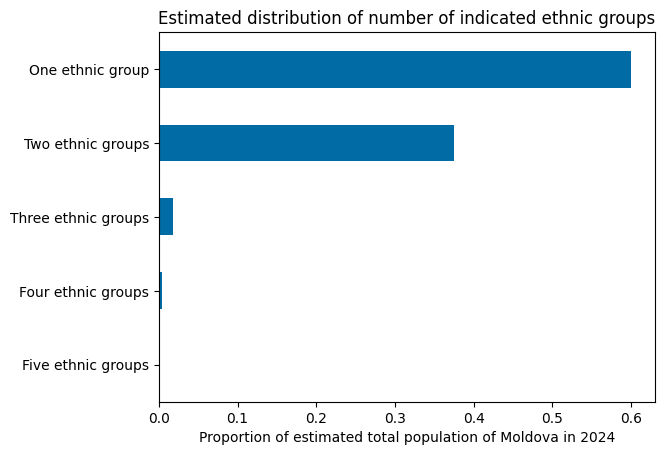

In [108]:

fig, ax = plt.subplots()

df_identity_count['count_normalized_all'].sort_values().plot(ax=ax,
                                                             kind='barh')
ax.set_xlabel("Proportion of estimated total population of Moldova in 2024")
ax.set_title(
    "Estimated distribution of number of indicated ethnic groups")

In [109]:
# Simulating hypothetical multiple identity micro data for Moldova's Census 2024

## Preparing new dataframe with probabilities based on the ethnobarometer.

df_e_ptable = df_e_ethnicity

## Create new column names and rename them
new_col_names = vars_e.iloc[13:22].to_dict()['text']
new_col_names = {
    old: new.split(' - ')[1]
    for old, new in new_col_names.items()
}
df_e_ptable.rename(columns=new_col_names, inplace=True)

## Address faulty raw data that mixes up Q2_08 and Q2_09 with wrong translation.
df_e_ptable.rename(columns={
    'No else': 'Others',
    "Other": "None"
},
                   inplace=True)

# The Ethnobaromter did not include data on "Others" and "Not declared". We will therefore simulate two additional sample clusters of 400 respondents for each of those categories.

new_rows = [['Others'] + [0] * 8 + [1]
            for _ in range(400)] + [['Not declared'] + [0] * 8 + [1]
                                    for _ in range(400)]

new_data = pd.DataFrame(new_rows, columns=df_e_ptable.columns)

# Concatenate existing and new data
df_e_ptable = pd.concat([df_e_ptable, new_data], ignore_index=True)

# Merging estimated 2024 probabilities into df
df_e_ptable = pd.merge(df_e_ptable,
                       df,
                       left_on="ETHN-GROUP",
                       right_on="ethnicity")

# Replacing value 1 with actual name of ethnicity for merging all columns into one list, i.e. a fictional person.
df_e_ptable = df_e_ptable.apply(lambda x: x.replace(1, x.name))

# Creating a list containing all ethnic identities mentioned per person
df_e_ptable['identity_list'] = df_e_ptable.loc[:, :'None'].apply(
    lambda row: [row['ETHN-GROUP']] +
    [col for col, val in row[row != 0].items() if col != 'ETHN-GROUP'],
    axis=1)

# Calculating weights based on 2024 population estimate
sample_proportion = 1 / df_e_ptable['ETHN-GROUP'].nunique()
df_e_ptable['weight'] = df_e_ptable['2024_p'] / sample_proportion
df_i = df_e_ptable[['ETHN-GROUP', 'identity_list', 'weight']]

# Convert the lists to tuples
df_i = df_i.copy()
df_i.loc[:, 'identity_tuple'] = df_i.loc[:, 'identity_list'].apply(tuple)

# Calculate frequency of each identity_tuple and sum the weights
identity_weights = df_i.groupby('identity_tuple')['weight'].sum()
# Create a new DataFrame
identity_df = pd.DataFrame(identity_weights).reset_index()
# Rename the columns
identity_df.columns = ['identity_list', 'weight']
# Normalize the weights
identity_df['weight'] = identity_df['weight'] / identity_df['weight'].sum()

# Drawing sample for a simulated Moldovan population

samples = np.random.choice(identity_df['identity_list'],
                           size=df['2024'].sum(),
                           p=identity_df['weight'])
samples_df = pd.DataFrame(samples, columns=['identity_list'])
samples_df['identity_list'] = samples_df['identity_list'].apply(
    lambda x: tuple(item for item in x if item != 'None'))

# Counting the occurance of each ethnicity mentioned in each row

from collections import Counter

# Flattening the list of tuples
flat_list = [
    item for sublist in samples_df['identity_list'].tolist()
    for item in sublist
]
# Counting the occurrences of each item
counts = Counter(flat_list)
samples_df_counts = pd.DataFrame.from_dict(counts,
                                           orient='index').reset_index()
samples_df_counts.columns = ['ethnicity', '2024_multiple']

# Normalizing counts
samples_df_counts['2024_multiple_p'] = samples_df_counts[
    '2024_multiple'] / samples_df_counts['2024_multiple'].sum()

In [110]:
identity_df

,identity_list,weight
0,"(Bulgarian, Gagauz)",0.000369
1,"(Bulgarian, Moldovan)",0.004963
2,"(Bulgarian, Moldovan, Gagauz)",0.000082
3,"(Bulgarian, Moldovan, Russian)",0.000574
4,"(Bulgarian, Moldovan, Ukrainian)",0.000041
...,...,...
79,"(Ukrainian, Moldovan, Russian)",0.002652
80,"(Ukrainian, None)",0.014584
81,"(Ukrainian, Others)",0.000265
82,"(Ukrainian, Romanian)",0.000133


In [111]:
df.drop('ethnicity', axis=1)

,2024,2024_p,2004,2014
0,1848670,0.767335,2564849,2068058.0
1,193197,0.080191,73276,192800.0
2,123586,0.051297,282406,181035.0
3,81630,0.033883,201218,111726.0
4,97205,0.040347,147500,126010.0
5,38236,0.015871,65662,51867.0
6,9356,0.003883,12271,9323.0
7,13879,0.005761,22130,13900.0
8,3448,0.001431,14020,50082.0


In [112]:
samples_df_counts

,ethnicity,2024_multiple,2024_multiple_p
0,Romanian,488182,0.141509
1,Moldovan,2139018,0.620036
2,Russian,369064,0.106980
3,Ukrainian,224833,0.065172
4,Gagauz,120874,0.035038
5,Bulgarian,65034,0.018851
6,Others,28502,0.008262
7,Roma,10643,0.003085
8,Not declared,3681,0.001067


In [113]:
df

,ethnicity,2024,2024_p,2004,2014
0,Moldovan,1848670,0.767335,2564849,2068058.0
1,Romanian,193197,0.080191,73276,192800.0
2,Ukrainian,123586,0.051297,282406,181035.0
3,Russian,81630,0.033883,201218,111726.0
4,Gagauz,97205,0.040347,147500,126010.0
5,Bulgarian,38236,0.015871,65662,51867.0
6,Roma,9356,0.003883,12271,9323.0
7,Others,13879,0.005761,22130,13900.0
8,Not declared,3448,0.001431,14020,50082.0


In [114]:
df_backup = df.copy()

In [115]:
# Code for obtaining plots showing 'Total Response Grouping'

# Preparing df for plotting

# df = df.drop('ethnicity', axis=1)
# df = df.loc[:, :"2024"].apply(lambda x: x / sum(x))
df = pd.merge(df.loc[:, ('ethnicity', '2024', "2014", "2004")],
              samples_df_counts.loc[:,('ethnicity', '2024_multiple')],
              left_on="ethnicity",
              right_on="ethnicity")
df = df.rename(columns={
    "2024": "2024_single_ethnicity",
    '2024_multiple': '2024_multiple_ethnicity'
})
df.index = df['ethnicity']
df = df.drop('ethnicity', axis=1)
df = df.apply(lambda x: x.astype(float))

In [116]:
df.loc

In [117]:
df = df.apply(lambda x: x / sum(x), axis=0)

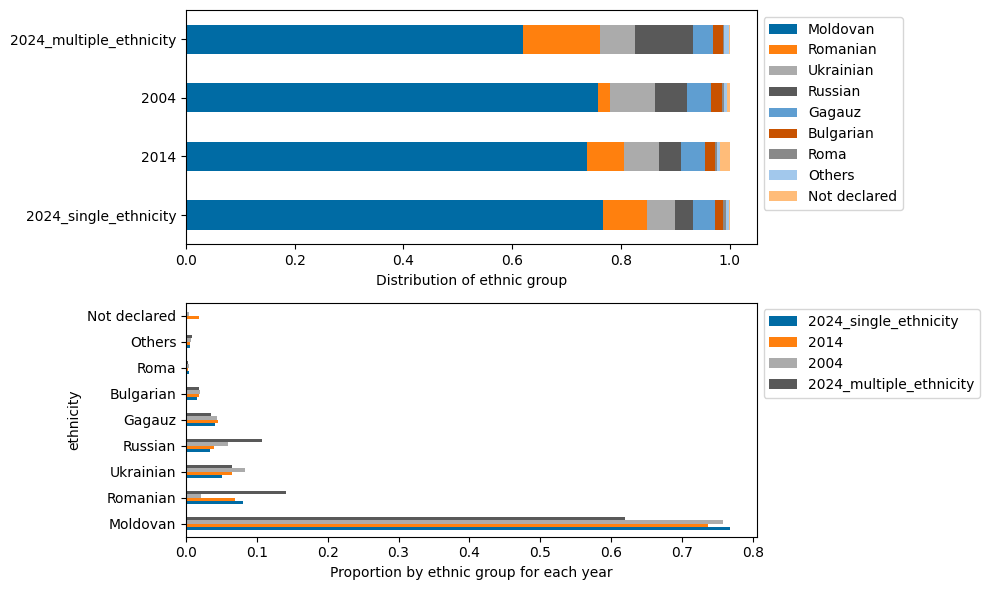

In [118]:
# Creating the plot
# plt.style.use('seaborn-v0_8-dark')
plt.style.use('tableau-colorblind10')

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))

df.T.plot(ax=ax1, kind='barh', stacked=True)
df.plot(ax=ax2, kind='barh')

ax1.set_xlabel("Distribution of ethnic group")
ax2.set_xlabel("Proportion by ethnic group for each year")

ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax2.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()

#### 2. Single and Combination Grouping

In order to demonstrate what single and combination grouping looks like in practice, we can again use our simulated and hypothetical data for Moldova in 2024. As noted above, this approach retains the heterogeneity of society best by grouping the various permutations of identity combintations as they are reported. The main issue is that there can be a challenging number of permutations that are not intiuitive for data users.

In our hypothetical sample, we have 57 different response groupings. This is unpractical and a "commonly practiced solution is to aggregate combinations with small cell counts into broader categories as appropriate (e.g., “other dual combinations”, “three or more ethnic groups”, or sometimes a single “mixed” category; Statistics New Zealand 2005) Yao 2021"

> Important here: The order of responses can be disregarded for grouping, unless the question specifically asked to provide a prioritization of identities. However, even in that case, some respondents may not provide a prioritization and treatment of the data becomes very challenging.

The table belwo shows the count of each of the 57 possible combinations (based on the Ethnobaromter 2020) for Moldova's estimated population in 2024.

In [119]:
# Converting tuples to sets in order to disregard ordering
samples_df['identity_set'] = samples_df['identity_list'].apply(
    lambda x: set(x))

# Flatten the list of sets and count the values
counter = Counter([
    item for sublist in samples_df['identity_set'].tolist() for item in sublist
])

# Create a summary list of all possible permutations
single_combination = samples_df['identity_set'].value_counts()

pd.DataFrame(single_combination)

,count
identity_set,
{Moldovan},1242762
"{Romanian, Moldovan}",420627
"{Moldovan, Russian}",235535
"{Moldovan, Ukrainian}",124777
{Gagauz},66120
{Ukrainian},35264
{Russian},33762
"{Moldovan, Gagauz}",30407
{Romanian},30183


This table is not easily readable and not appropriate for public consumption. It is therfore instructive to show how a shorter table would look like. We can achieve this by grouping all entries below a certain threshold count (in our case we, arbitrarily, chose 10,000) into a new category called "Other combinations".

In [120]:
# Creating a shortened list with the threshold of 10,000
# Determine the threshold
threshold = 10000

# Create a mask for the values that are below the threshold
mask = single_combination < threshold

# Calculate the sum of the values that are below the threshold
sum_below_threshold = single_combination[mask].sum()

# Remove the entries below the threshold
single_combination = single_combination[~mask]

# Add a new entry for the sum of the values below the threshold
other_combinations_series = pd.Series(
    {'Other combinations': sum_below_threshold})

# Use pandas.concat to combine the series
single_combination = pd.concat([single_combination, other_combinations_series])

# Now data contains the original entries above the threshold and a single entry for the sum of those below the threshold
pd.DataFrame(single_combination)

,0
{Moldovan},1242762
"{Romanian, Moldovan}",420627
"{Moldovan, Russian}",235535
"{Moldovan, Ukrainian}",124777
{Gagauz},66120
{Ukrainian},35264
{Russian},33762
"{Moldovan, Gagauz}",30407
{Romanian},30183
"{Ukrainian, Russian}",25443


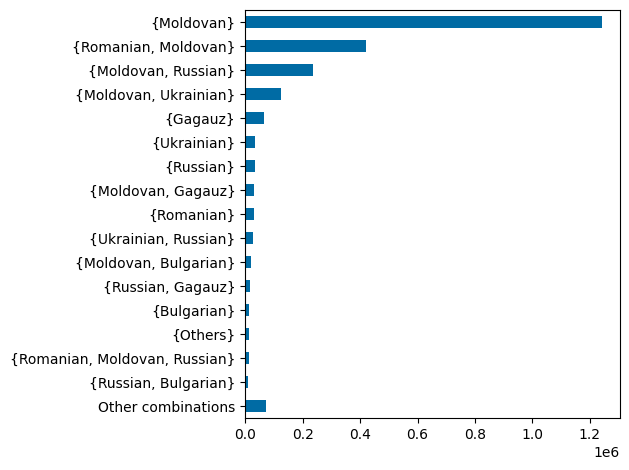

In [121]:
# Plotting the table

# A small operation to place 'Other combinations' at the end of the plot
single_combination_other = single_combination[single_combination.index ==
                                              'Other combinations']
single_combination = single_combination[
    single_combination.index != 'Other combinations']

# Now we can sort the dataframe
single_combination = single_combination.sort_values(ascending=True)

# And append the 'Other combinations' row back
single_combination = pd.concat([single_combination_other, single_combination])

# Now plot the data
fig, ax = plt.subplots()
single_combination.plot(ax=ax, kind='barh')
plt.tight_layout()

### Reduction Methods
#### 3. Administrative prioritization

Use of administrative-prioritization data is essentially the same as using self-prioritized data. All methods described in the section are therefore also applicable for this approach. The key difference here is that the prioritization is the result of an authority's decision, as opposed to the individual. As noted above, this is not inline with the primacy of voluntary self-identification and should be employed with <mark>**extreme care and justification**</mark>.

In some contexts, such as New Zealand, administrative prioritization is used in a way that responds to the the country's colonial history and impact on indigenous communities. The country uses a hierarchical approach to administrative-prioritization, that prioritizes indigenous groups and minority communities. In practice this means that a person mentioning an indigenous group and being European will always be counted as a person belonging to the indigenous group indicated.

In the context of Moldova, this approach is challenging given the very complex historical and social set-up of the country. The effect of the Soviet Union's aggressive policy on "nationalities" in Moldova would to some extent justify a decolonization perspective in administrative-prioritization. However, the existence of numerous minority communities would render this approach highly problematic in terms of Moldova's obligations to uphold minority rights.

#### 4. Self-Prioritization
##### Overview

If respondents are specifically asked in a survey or during census enumeration to indicate whether one of their ethnic identities can be described as "dominant", "main", or "best", then it is possible to treat data differently. There are a number of options to use self-prioritized multiple identity data.

1. Only the dominant ethnicity could be used for analytical purposes, ignoring potential second and third identities. This is **discouraged** by the HCNM, as it represents a <mark>violation of the primacy of voluntary self-identification</mark>.
2. Analyse and visualize in-group diversity by showing the proportions of other identities.

A serious challenge for the self-prioritization approach is handling respondents that refuse to answer the prioritization question. For example: An individual identifies with two distinct ethnic groups and does not want to prioritize one over the other - a typical example are children that have parents identifying with different ethnic groups. For such individuals retention methods should be used. While using such methods in an auxilliary fashion with self-prioritization data is possible, it is statistically challenging and may not be intitutive for data users.

##### Showing in-group diversity with self-prioritized data

The Ethnobarometer 2020 is self-prioritized data and we can use it to show some sample use cases for such data. First, we use the raw data of the Ethnobarometer to create a pair-wise table showing the probabilities of the relationship between a "dominant" identity with other identities. The following table uses "ETHN-GROUP" as the "dominant" group and puts it into a relationship with other identities.

In [125]:
# Ethnobarometer data recast as pair-wise probabilities of dominant and other identities

# Overwrite df_e_ethnicity_grouped with fresh data
df_e_ethnicity_grouped = df_e_ethnicity.groupby('ETHN-GROUP').sum()

# Create new column names and rename them
new_col_names = vars_e.iloc[13:22].to_dict()['text']
new_col_names = {
    old: new.split(' - ')[1]
    for old, new in new_col_names.items()
}
df_e_ethnicity_grouped.rename(columns=new_col_names, inplace=True)
# Address faulty raw data that mixes up Q2_08 and Q2_09 with wrong translation.
df_e_ethnicity_grouped.rename(columns={
    'No else': 'Others',
    "Other": "None"
},
                              inplace=True)

# Substituting 'None' answer with `ETHN-GROUP` in order to better visualize persons who only indicated one ethnic group.
for i in df_e_ethnicity_grouped.index:
    df_e_ethnicity_grouped.loc[i, i] = df_e_ethnicity_grouped.loc[i, 'None']
# Drop the now obsolete 'None' variable
df_e_ethnicity_grouped = df_e_ethnicity_grouped.drop(['None'], axis=1)

# Simulating two more sample clusters for "Others" and "Not declared" based on 2024 population estimate, as Ethnobarometer does not yield this information.
others = 400
not_declared = 400
df_e_ethnicity_grouped.loc['Others', 'Others'] = others
df_e_ethnicity_grouped.loc['Not declared', 'Not declared'] = not_declared
df_e_ethnicity_grouped.replace(np.nan, 0, inplace=True)

# Adjust cluster sample size to reflect 2024 population estimate
for group in df_e_ethnicity_grouped.index:
    df_e_ethnicity_grouped.loc[group] = df_e_ethnicity_grouped.loc[
        group].apply(lambda x: x * df.loc[group]['2024_single_ethnicity'])

# Getting proportions via colum-wise operation
df_e_ethnicity_grouped_column = df_e_ethnicity_grouped.div(
    df_e_ethnicity_grouped.sum(axis=1), axis=0)

# Displaying the df (rounding to 3 decimals)
round(df_e_ethnicity_grouped_column, 3)

,Moldovan,Romanian,Russian,Ukrainian,Bulgarian,Gagauz,Roma,Others,Not declared
ETHN-GROUP,,,,,,,,,
Bulgarian,0.320,0.002,0.253,0.037,0.346,0.039,0.000,0.002,0.0
Gagauz,0.163,0.000,0.144,0.015,0.024,0.641,0.000,0.012,0.0
Moldovan,0.625,0.195,0.118,0.041,0.010,0.007,0.000,0.005,0.0
Roma,0.298,0.012,0.102,0.007,0.005,0.010,0.559,0.007,0.0
Romanian,0.670,0.300,0.000,0.010,0.005,0.000,0.005,0.010,0.0
Russian,0.428,0.000,0.386,0.109,0.029,0.024,0.005,0.019,0.0
Ukrainian,0.542,0.007,0.177,0.256,0.002,0.012,0.000,0.005,0.0
Others,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.0
Not declared,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0


This table can be visualized in a number of ways. First, we show how a regular <mark>bar chart</mark>.

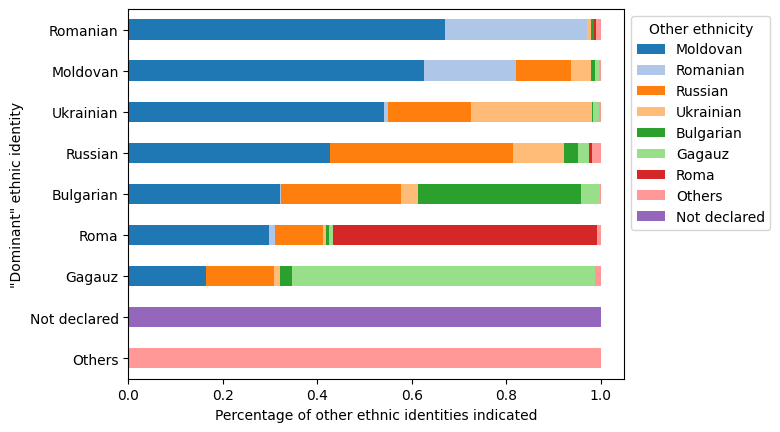

In [126]:
# Horizontal bar chart showing in-group diversity of Ethnobarometer data
fig, ax = plt.subplots()

plt.style.use('tableau-colorblind10')

colors = sns.color_palette('tab20')

df_e_ethnicity_grouped_column.sort_values('Moldovan').plot(ax=ax,
                                                           kind='barh',
                                                           stacked=True,
                                                           color=colors)
ax.set_xlabel("Percentage of other ethnic identities indicated")
ax.set_ylabel('"Dominant" ethnic identity')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Other ethnicity")

# # Adding the values
# for p in ax.patches:
#     left, bottom, width, height = p.get_bbox().bounds
#     if width > 0:
#         ax.annotate(f'{width:.3f}', xy=(left+width/2, bottom+height/2),
#                     xytext=(0,0), textcoords='offset points', ha='center', va='center')

Another way of showing the relationship between dominant and other identities is a <mark>heat map</mark>. The plot below is a simple representation of the Ethnobaromter 2020 data in these terms.

Text(95.72222222222221, 0.5, '"Dominant" ethnic identity')

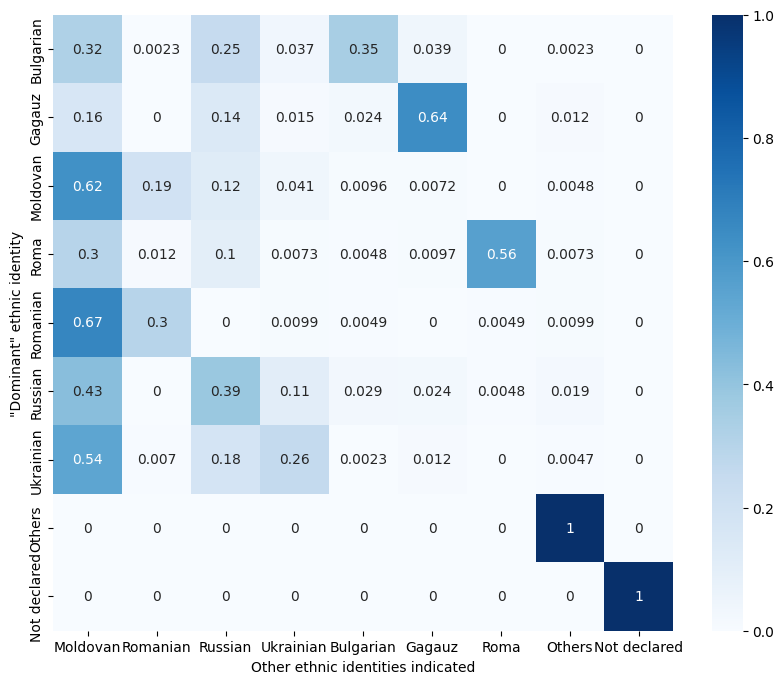

In [127]:
# Create a heatmap of the relationship between main ethnic group and other ethnic groups

fig, ax = plt.subplots(figsize=(10, 8))
colormap = sns.color_palette("Blues", 1000)  #"YlGnBu"

sns.heatmap(df_e_ethnicity_grouped_column, annot=True, cmap=colormap, ax=ax)

ax.set_xlabel("Other ethnic identities indicated")
ax.set_ylabel('"Dominant" ethnic identity')

Finally, yet another way, of visualizing in-group diversity is using <mark>tree maps</mark>. The gridplot below is a simple version of that approach. Each tree map describes one dominant identity and the relative size of each other identity noted during that process.

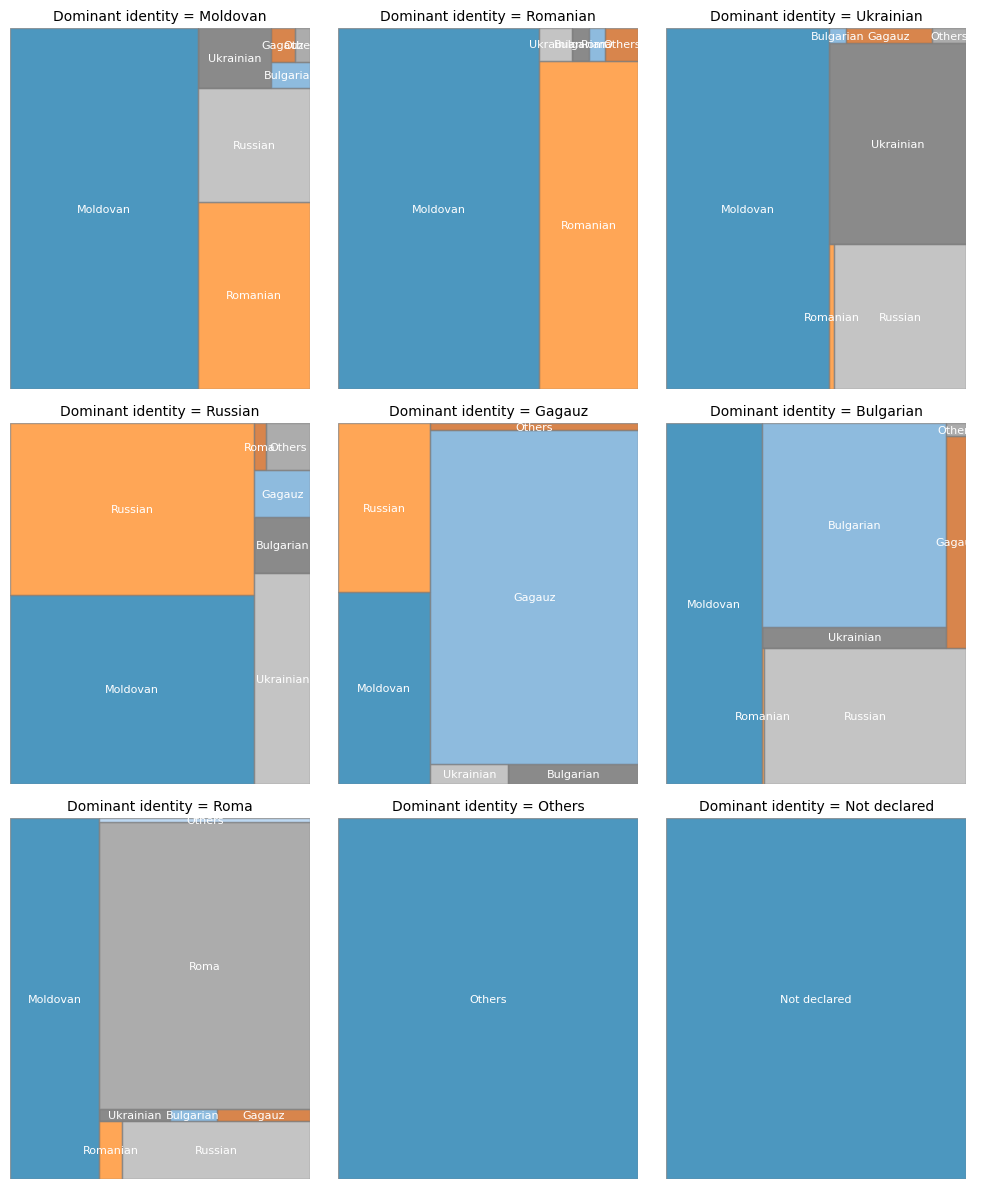

In [130]:
import squarify

# Creating a tree map of all "dominant" identities

# Create the subplots
fig, axs = plt.subplots(3, 3,
                        figsize=(10,
                                 3 * 4))  # Adjust the figure size if needed
# fig.patch.set_facecolor('darkgrey')

# Flatten the axes array
axs = axs.ravel()

# Iterate through each group and each ax
for ax, group in zip(axs, df.index):
    df_treemap = pd.DataFrame(df_e_ethnicity_grouped_column.loc[group],
                              index=df_e_ethnicity_grouped_column.columns)
    df_treemap = df_treemap.loc[df_treemap[group] > 0]
    ax.set_title("Dominant identity = " + group, fontsize=10)
    squarify.plot(
        sizes=df_treemap[group],
        label=df_treemap.index,
        color=[
            '#006BA4', '#FF800E', '#ABABAB', '#595959', '#5F9ED1', '#C85200',
            '#898989', '#A2C8EC', '#FFBC79', '#CFCFCF'
        ],
        #                   color = sns.color_palette("magma",
        #                                    len(df_e_ethnicity_grouped_column)),
        text_kwargs={
            'fontsize': 8,
            'color': 'white'
        },
        ec='grey',
        alpha=.7,
        ax=ax,
        pad=False)
    ax.axis('off')

plt.tight_layout()
plt.show()


# Annex: Thinking about Multiple Identity in Statistical Terms

It is helpful to think about the various possible combinations of multiple identities as $k$ mutually exclusive outcomes in a *multinomial distribution*, where each outcome (i.e. multiple identity combination) $k$ has a constant probability $p_1,...,p_k$.

>The probability mass function of the multinomial distribution is given by:

$$ P(X_1=x_1, \ldots X_k=x_k) = \frac{n!}{(x_1!x_2! \ldots x_k!)} p_1^{x_1} \ldots p_k^{x_k} $$

Assuming that we know all probabilities for all mutually exclusive possible combinations of multiple identities occuring in society, we can then use the multinomial distribution to simulate $n$ independent trials (i.e. persons).

1. One challenge of using the multinomial distribution relates to the assumption that there are a finite number of possible outcomes for each trial, and the likelihood of any event occurring is constant throughout the experiment. However, at least in theory, there is an *infinite* number of possible combinations of identities, in line with the primacy of voluntary self-identification. As it is impossible to know the probabilities of all combinations, we can subsume all unknown combinations into the category "Others", which is:

$$ 1 - \sum{p_1^{known} \ldots p_i^{known}} $$

2. The multinomial distribution also requires independence of outcomes. However, we know that identities are often dependent on each other. This dependence therefore needs to be reflected in the probabilities of mutually exclusive outcomes.

> Using multinomial distribution is but one option to deal with multiple identities in statistical terms. For more complex representations, mixed membership models may be appropriate allowing for assigning relative proportions between identities. However, this requires complex, and (more) challenging data.



# Further reading

- Aspinall, Peter J. “What Kind of Mixed Race/Ethnicity Data Is Needed for the 2020/21 Global Population Census Round: The Cases of the UK, USA, and Canada.” Ethnic and Racial Studies 41, no. 11 (September 2, 2018): 1990–2008.
- Balestra, Carlotta, and Lara Fleischer. Diversity Statistics in the OECD: How Do OECD Countries Collect Data on Ethnic, Racial and Indigenous Identity? OECD Statistics Working Papers no. 2018/09. Vol. 2018/09. OECD Statistics Working Papers, November 12, 2018. https://www.oecd.org/en/publications/diversity-statistics-in-the-oecd_89bae654-en.html.
- Bhopal, R. “Glossary of Terms Relating to Ethnicity and Race: For Reflection and Debate.” Journal of Epidemiology & Community Health 58, no. 6 (June 1, 2004): 441–45.
- Cokley, Kevin. “Critical Issues in the Measurement of Ethnic and Racial Identity: A Referendum on the State of the Field.” Journal of Counseling Psychology 54, no. 3 (July 2007): 224–34.
- Collins, Patricia, and John Solomos. The SAGE Handbook of Race and Ethnic Studies. 1 Oliver’s Yard, 55 City Road, London EC1Y 1SP United Kingdom: SAGE Publications Ltd. 2010.
- Hirschman, Charles. “The Origins and Demise of the Concept of Race.” Population & Development Rev 30, no. 3 (September 2004): 385–415.
- Morning, Ann. “Ethnic Classification in Global Perspective: A Cross-National Survey of the 2000 Census Round.” Popul Res Policy Rev 27, no. 2 (April 2008): 239–72.
- Roth, Wendy D. “The Multiple Dimensions of Race.” Ethnic and Racial Studies 39, no. 8 (June 20, 2016): 1310–38.
- Smedley, Audrey, and Brian D. Smedley. “Race as Biology Is Fiction, Racism as a Social Problem Is Real: Anthropological and Historical Perspectives on the Social Construction of Race.” American Psychologist 60, no. 1 (2005): 16–26.
- Yao, Esther. “Classifying Ethnicity in Multi-Ethnic Contexts: Implications of Methodological Decisions on Quantitative Research.” University of Auckland. 2022.
- Yao, Esther S., Kane Meissel, Pat Bullen, Polly Atatoa Carr, Terryann Clark, and Susan Morton. “Classifying Multiple Ethnic Identifications: Methodological Effects on Child, Adolescent, and Adult Ethnic Distributions.” Demographic Research 44 (March 16, 2021): 481–512.
